In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from skimage.color import rgb2gray

from pywsi.io import WSIReader
from pywsi.io.operations import read_as_rgb

from pywsi.segmentation import poisson_deconvolve, perform_binary_cut, max_clustering
from pywsi.segmentation import collapse_labels, collapse_small_area, laplace_of_gaussian
from pywsi.segmentation import gmm_thresholding, label_nuclei

from pywsi.normalization import MacenkoNormalization
from pywsi.normalization import ReinhardNormalization
from pywsi.normalization import VahadaneNormalization
from pywsi.normalization import XuNormalization

import pickle
import seaborn as sns

import glob
from tqdm import tqdm, tqdm_notebook

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


Populating the interactive namespace from numpy and matplotlib


In [2]:
PATCH_SIZE = 128

In [3]:
normal = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/normal/normal_100.tif'
tumor = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/tumor/tumor_004.tif'

tumor_wsi = WSIReader(tumor, 40)
normal_wsi = WSIReader(normal, 40)

In [4]:
x0 = int(59792/2)#30000
y0 = int(233184/2)
tumor_rgb = tumor_wsi.get_patch_by_level(x0, y0, level=0, patch_size=PATCH_SIZE)

x0 = int(97792/2)
y0 = int(212992/1.5)
normal_rgb = normal_wsi.get_patch_by_level(x0, y0, level=0, patch_size=PATCH_SIZE)

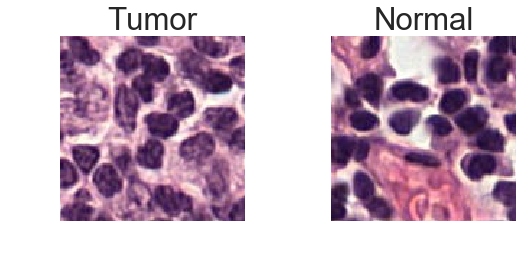

In [5]:
sns.set_context('talk', font_scale=2)
sns.set_style('white')
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(121)
ax.set_axis_off()
ax.imshow(tumor_rgb)
ax.set_title('Tumor')

ax = plt.subplot(122)
ax.set_axis_off()
ax.imshow(normal_rgb)
ax.set_title('Normal')

fig.tight_layout()
fig.savefig('presentation_images/normal_tumor_example.pdf')


In [6]:
macenko_fit = {}
H_channel_m = {}
E_channel_m = {}

macenko_fit['tumor'] = MacenkoNormalization()
macenko_fit['tumor'].fit(np.asarray(tumor_rgb).astype(np.uint8))

macenko_fit['normal'] = MacenkoNormalization()
macenko_fit['normal'].fit(np.asarray(normal_rgb).astype(np.uint8))

H_channel_m['tumor'] = macenko_fit['tumor'].get_hematoxylin_channel(tumor_rgb)
E_channel_m['tumor'] = macenko_fit['tumor'].get_eosin_channel(tumor_rgb)

H_channel_m['normal'] = macenko_fit['normal'].get_hematoxylin_channel(normal_rgb)
E_channel_m['normal'] = macenko_fit['normal'].get_eosin_channel(normal_rgb)



In [7]:
vahadane_fit = {}
H_channel_v = {}
E_channel_v = {}

vahadane_fit['tumor'] = VahadaneNormalization()
vahadane_fit['tumor'].fit(np.asarray(tumor_rgb).astype(np.uint8))

vahadane_fit['normal'] = VahadaneNormalization()
vahadane_fit['normal'].fit(np.asarray(normal_rgb).astype(np.uint8))


H_channel_v['tumor'] = vahadane_fit['tumor'].get_hematoxylin_channel(tumor_rgb)
E_channel_v['tumor'] = vahadane_fit['tumor'].get_eosin_channel(tumor_rgb)

H_channel_v['normal'] = vahadane_fit['normal'].get_hematoxylin_channel(normal_rgb)
E_channel_v['normal'] = vahadane_fit['normal'].get_eosin_channel(normal_rgb)


In [8]:
xu_fit = {}
H_channel_x = {}
E_channel_x = {}

xu_fit['tumor'] = XuNormalization()
xu_fit['tumor'].fit(np.asarray(tumor_rgb).astype(np.uint8))

xu_fit['normal'] = XuNormalization()
xu_fit['normal'].fit(np.asarray(normal_rgb).astype(np.uint8))


H_channel_x['tumor'] = xu_fit['tumor'].get_hematoxylin_channel(tumor_rgb)
E_channel_x['tumor'] = xu_fit['tumor'].get_eosin_channel(tumor_rgb)

H_channel_x['normal'] = xu_fit['normal'].get_hematoxylin_channel(normal_rgb)
E_channel_x['normal'] = xu_fit['normal'].get_eosin_channel(normal_rgb)


# Segmenting based on Graph cuts

The `perform_binary_cut` method in `pywsi.segmentation.graph_cut` implements [Boykov et al.'s method](http://www.csd.uwo.ca/~yuri/Papers/ijcv06.pdf) which uses the Max-flow/Min-cut theorem to perform segmentation. The input to this method are two probability matrices: background and foreground. These matrices are estimated following the approach in [Al-Kofahi et al.](https://ieeexplore.ieee.org/document/5306149/)

Consider the normalized image histogram $h(i)$ where $i=$ intensity of a pixel:

$$
h(i) = P_0 \times p(i|0) + P_1 \times p(i|1)
$$

$P_0$ and $P_1$ are prior probabilites of belonging to background and foreground respectively. For a given threshold $t$, they can be estimated by:

\begin{align*}
P_0(t) &= \sum_{i=0}^t h(i)\\
P_1(t) &= \sum_{i=t+1}^{I_\text{max}} h(i)\\
\mu_0(t) &= \frac{1}{P_0(t)} \sum_{i=0}^t i \times h(i)\\
\mu_1(t) &= \frac{1}{P_1(t)} \sum_{i=t+1}^{I_\text{max}} i \times h(i)\\
\end{align*}

The optimals threshold $t^*$ is found by :
$$
t^* =  arg\min_t \{ \mu - P_0(t) (\ln{P_0(t)} + \mu_0(t) \ln{\mu_0(t)}) - P_1(t) (\ln{P_1(t)} + \mu_1(t) \ln{\mu_1(t)})
$$

We will first decompose the original 3 channel image into 2 channels: H & E. H channel will have the nuclei enriched while the E channel will have the tissue related things.



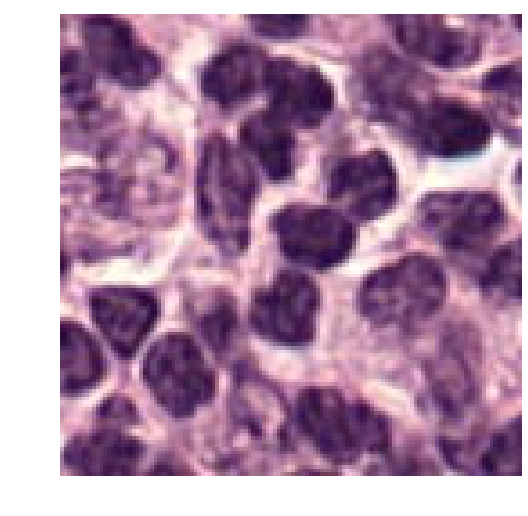

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
ax.set_axis_off()
ax.imshow(tumor_rgb)
fig.tight_layout()
fig.savefig('presentation_images/tumor_rgb.pdf')

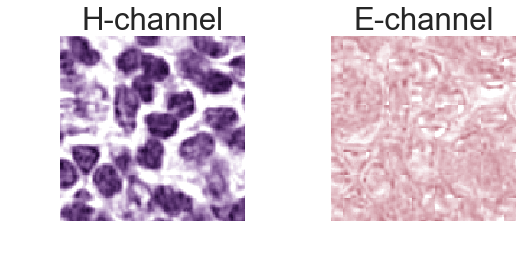

In [10]:
key = 'tumor'
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(121)
ax.set_axis_off()
ax.imshow(H_channel_v[key]/255)
ax.set_title('H-channel')
ax = plt.subplot(122)
ax.set_axis_off()
ax.imshow(E_channel_v[key]/255)
ax.set_title('E-channel'.format(key))
fig.tight_layout()
fig.savefig('presentation_images/h_e_channel_tumor.pdf')

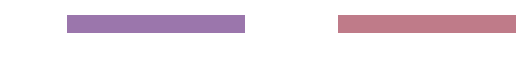

In [11]:
vahadane_fit['tumor'].get_both_stains()
plt.tight_layout()
plt.savefig('presentation_images/tumor_stains.pdf')

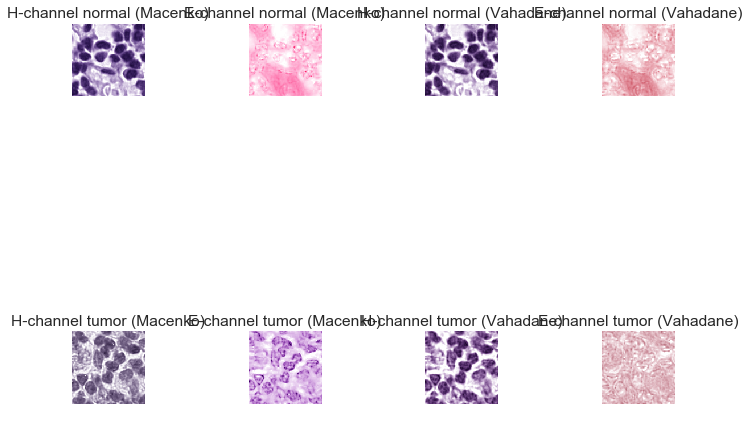

In [12]:
keys = ['normal', 'tumor']
fig = plt.figure(figsize=(10, 10))
index = 1
sns.set_context('talk')

for key in keys:
    ax = plt.subplot(2,4,index)
    ax.set_axis_off()
    ax.imshow(H_channel_m[key]/255)
    ax.set_title('H-channel {} (Macenko)'.format(key))
    
    ax = plt.subplot(2,4,index+1)
    ax.set_axis_off()
    ax.imshow(E_channel_m[key]/255)
    ax.set_title('E-channel {} (Macenko)'.format(key))

    
    ax = plt.subplot(2,4,index+2)
    ax.set_axis_off()
    ax.imshow(H_channel_v[key]/255)
    ax.set_title('H-channel {} (Vahadane)'.format(key))

    ax = plt.subplot(2,4,index+3)
    ax.set_axis_off()
    ax.imshow(E_channel_v[key]/255)
    ax.set_title('E-channel {} (Vahadane)'.format(key))
    index += 4

fig.tight_layout()

We will work with the Vahadane channel for the rest of our analysis.

In [13]:
nuclei_stain = H_channel_v

# Poisson probabilities

In [14]:
fg = {}
bg = {}
bg['normal'], fg['normal'], t = poisson_deconvolve(rgb2gray(nuclei_stain['normal']).astype(int))
bg['tumor'], fg['tumor'], t = poisson_deconvolve(rgb2gray(nuclei_stain['tumor']).astype(int))

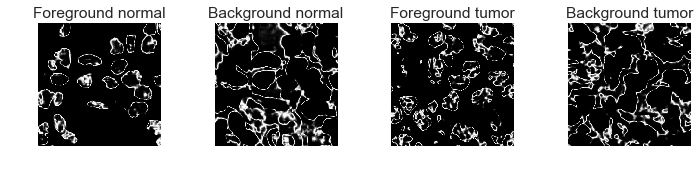

In [15]:
keys = ['normal', 'tumor']
fig = plt.figure(figsize=(10, 10))
index = 1
sns.set_context('talk')

for key in keys:
    ax = plt.subplot(1,4,index)
    ax.set_axis_off()
    ax.imshow(fg[key], cmap='gray')
    ax.set_title('Foreground {}'.format(key))
                 
    ax = plt.subplot(1,4,index+1)
    ax.set_axis_off()
    ax.imshow(bg[key], cmap='gray')
    ax.set_title('Background {}'.format(key))
    index += 2
    
fig.tight_layout()

# GMM based segmentation

In [16]:
gmm_threshold = {}
gmm_threshold['normal'], _ = gmm_thresholding(rgb2gray(nuclei_stain['normal']))
gmm_threshold['tumor'], _ = gmm_thresholding(rgb2gray(nuclei_stain['tumor']))

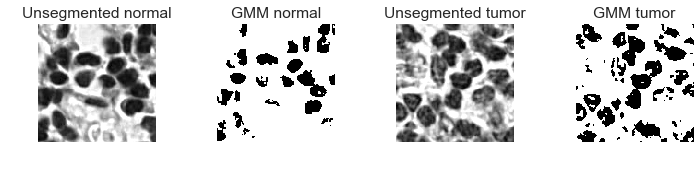

In [17]:
keys = ['normal', 'tumor']
fig = plt.figure(figsize=(10, 10))
index = 1
sns.set_context('talk')
for key in keys:
    ax = plt.subplot(1, 4, index)
    ax.set_axis_off()
    ax.imshow(rgb2gray(nuclei_stain[key]) , cmap='gray')
    ax.set_title('Unsegmented {}'.format(key))
    
    ax = plt.subplot(1, 4, index+1)
    ax.set_axis_off()
    ax.imshow(rgb2gray(nuclei_stain[key]) > gmm_threshold[key] , cmap='gray')
    ax.set_title('GMM {}'.format(key))
    index+=2
fig.tight_layout()

/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid alia

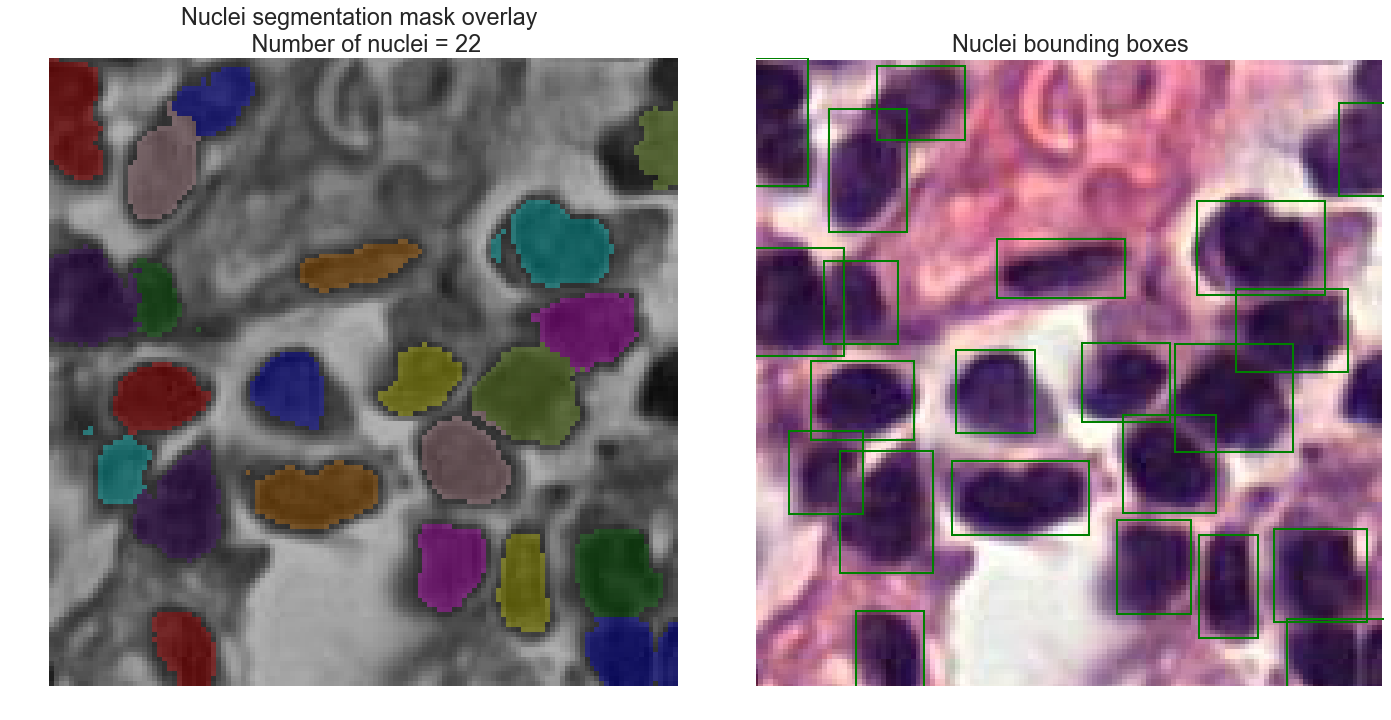

In [18]:
region_properties = {}
fg_mask = {}
import seaborn as sns
sns.set_context('talk', font_scale=1.5)
sns.set_style('white')
#fig, ax = plt.subplots(figsize=(8,8))
region_properties['normal'], fg_mask['normal'] = label_nuclei(normal_rgb,
                                                              local_max_search_radius=5, 
                                                              min_radius=3, 
                                                              max_radius=5,
                                                              min_nucleus_area=80,
                                                             savetopng='presentation_images/normal_segmented.pdf')
#plt.savefig('presentation_images/normal_segmented.')

/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/saket/anaconda3/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid alia

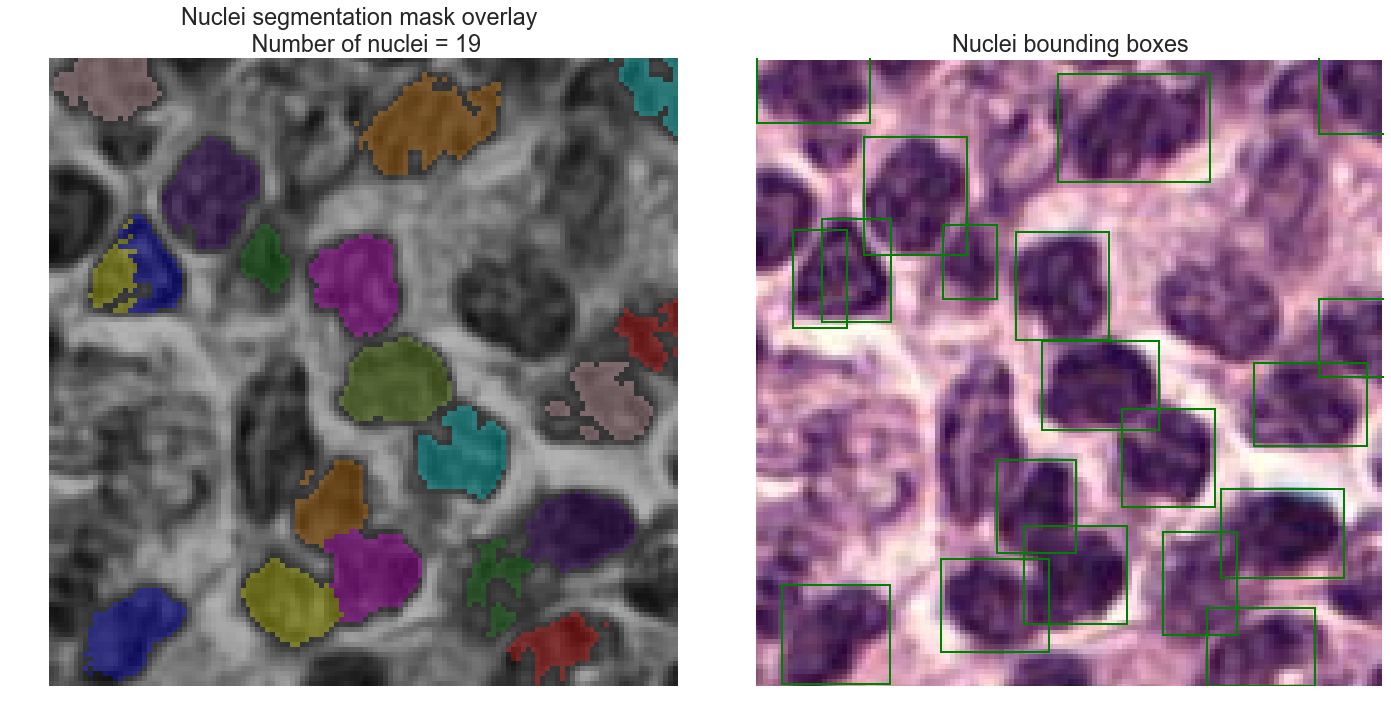

In [19]:
region_properties['tumor'], fg_mask['tumor'] = label_nuclei(tumor_rgb,
                                                            local_max_search_radius=3, 
                                                            min_radius=3, 
                                                            max_radius=5,
                                                            min_nucleus_area=80,
                                                            savetopng='presentation_images/tumor_segmented.pdf')
#local_max_search_radius=3, min_radius=5, max_radius=25, min_nucleus_area=100)


# Check interactively!

In [51]:
normal_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/baidu_images/level0_128px/training/normal/'
tumor_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/baidu_images/level0_128px/training/tumor/'

test_normal_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/baidu_images/level0_128px/testing/normal/'
test_tumor_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/baidu_images/level0_128px/testing/tumor/'

np.random.seed(42)

list_of_tumor_files = list(np.random.choice(glob.glob('{}*.png'.format(tumor_patches_dir)), 5000))
list_of_normal_files = list(np.random.choice(glob.glob('{}*.png'.format(normal_patches_dir)), 5000))

list_of_test_tumor_files = list(np.random.choice(glob.glob('{}*.png'.format(test_tumor_patches_dir)), 5000))
list_of_test_normal_files = list(np.random.choice(glob.glob('{}*.png'.format(test_normal_patches_dir)), 5000))



In [ ]:
level3_normal_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/baidu_images/level3_128px/training/normal/'
level3_tumor_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/baidu_images/level3_128px/training/tumor/'


np.random.seed(42)

level3_list_of_tumor_files = list(np.random.choice(glob.glob('{}*.png'.format(level3_tumor_patches_dir)),
                                                   5000))
level3_list_of_normal_files = list(np.random.choice(glob.glob('{}*.png'.format(level3_normal_patches_dir)), 5000))




In [45]:
def draw_nuclei(patch, local_max_search_radius=3, min_radius=4, max_radius=15, min_nucleus_area=100):
    patch = read_as_rgb(patch)
    
    label_nuclei(patch,
                 local_max_search_radius=local_max_search_radius, 
                 min_radius=min_radius,
                 max_radius=max_radius, 
                 min_nucleus_area=min_nucleus_area)
    

In [46]:
interact(draw_nuclei, patch=list_of_tumor_files)


interactive(children=(Dropdown(description='patch', options=('/Z/personal-folders/interns/saket/histopath_data…

<function __main__.draw_nuclei(patch, local_max_search_radius=3, min_radius=4, max_radius=15, min_nucleus_area=100)>

In [49]:
def draw_nuclei_Hchannel(patch, local_max_search_radius=3, min_radius=4, max_radius=15, min_nucleus_area=100):
    patch = read_as_rgb(patch)
    vahadane_fit = VahadaneNormalization()
    vahadane_fit.fit(np.asarray(patch).astype(np.uint8))
    H_channel_v = vahadane_fit.get_hematoxylin_channel(patch)
    
    label_nuclei(H_channel_v/255,
                 local_max_search_radius=local_max_search_radius, 
                 min_radius=min_radius,
                 max_radius=max_radius, 
                 min_nucleus_area=min_nucleus_area)
    


In [50]:
interact(draw_nuclei_Hchannel, patch=list_of_tumor_files)


interactive(children=(Dropdown(description='patch', options=('/Z/personal-folders/interns/saket/histopath_data…

<function __main__.draw_nuclei_Hchannel(patch, local_max_search_radius=3, min_radius=4, max_radius=15, min_nucleus_area=100)>

In [52]:
interact(draw_nuclei_Hchannel, patch=list_of_test_tumor_files)


interactive(children=(Dropdown(description='patch', options=('/Z/personal-folders/interns/saket/histopath_data…

<function __main__.draw_nuclei_Hchannel(patch, local_max_search_radius=3, min_radius=4, max_radius=15, min_nucleus_area=100)>